In [1]:
# Exploration notebook for speed algorithm
%matplotlib notebook
import numpy as np
import scipy.signal as signal
import matplotlib
import matplotlib.pyplot as plt


# plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 5)


FIBER_DISTANCE = 2.5
SAMPLING_RATE = 200
THRESHOLD = 0.001 # picometer
BIN_SIZE = 25


class Event:
    def __init__(self):
        self.timestamp = datetime.datetime.now()
        self.event_id = 0
        self.fiber1_id = 0
        self.fiber2_id = 0
        self.fiber1_sensors = []
        self.fiber2_sensors = []
        self.info = ''
        self.wav1 = []
        self.wav2 = []
        
        
def normalize_maxmin(wav):
    wav = (wav-np.min(wav))/(np.max(wav)-np.min(wav))
    return wav-wav[0]


        
# work with event2 with wls. Use min to aggregate data from difference sensors. Trial normalize signal then speed extraction
def calculate_speed_qc_alg1(event, lane_sensor):
    
    sos = signal.butter(1, 5, 'hp', fs=SAMPLING_RATE, output='sos')
    filtered_wav1 = signal.sosfilt(sos, event.wav1, axis=0)
    filtered_wav2 = signal.sosfilt(sos, event.wav2, axis=0)
    
    trace_temp1 = np.max(np.abs(filtered_wav1[:, lane_sensor]), axis=1)
    trace_temp2 = np.max(np.abs(filtered_wav2[:, lane_sensor]), axis=1)

    scaled_values_1 = normalize_maxmin(trace_temp1)
    scaled_values_2 = normalize_maxmin(trace_temp2)
    
    speed_valid = signal.correlate(scaled_values_1, scaled_values_2)
    
    peaks_temp2 = signal.find_peaks(scaled_values_2, prominence=0.1)
    peaks_temp1 = signal.find_peaks(scaled_values_1, prominence=0.1)
    if len(peaks_temp1[0]) == 0 or len(peaks_temp2[0]) == 0:
        speed_peak = 0
    else:
        speed_peak = -1*FIBER_DISTANCE / (peaks_temp1[0][0] - peaks_temp2[0][0]) * SAMPLING_RATE * 3.6
    
    if speed_valid.argmax() - len(event.wav1)!= 0:
        speed_corr = -1 * FIBER_DISTANCE / (speed_valid.argmax() - len(event.wav1)) * SAMPLING_RATE * 3.6
    else:
        speed_corr = 0
    return speed_corr, speed_peak


# work with event2 with wls. Use max of absolute value to aggregate data from difference sensors;
def calculate_speed_qc_alg2(event, lane_sensor):
    kk = np.min(event.wav1[:, lane_sensor], axis=0).argmin()
    # trace_temp1 = np.max(np.abs(event_list[j].wav1[:,lane_sensor_1]), axis=1)
    trace_temp1 = np.abs(event.wav1[:,kk])
    trace_temp2 = np.abs(event.wav2[:,kk])
    scaled_values_1 = normalize_maxmin(trace_temp1)
    scaled_values_2 = normalize_maxmin(trace_temp2)
#     trace_temp2 = np.max(np.abs(event.wav2[:, lane_sensor]), axis=1)
#     trace_temp1 = np.max(np.abs(event.wav1[:, lane_sensor]), axis=1)
    speed_valid = signal.correlate(scaled_values_1, scaled_values_2)
    if speed_valid.argmax() - len(event.wav1)!= 0:
        speed_corr = -1 * FIBER_DISTANCE / (speed_valid.argmax() - len(event.wav1)) * SAMPLING_RATE * 3.6
    else:
        speed_corr = 0

    peaks_temp2 = signal.find_peaks(scaled_values_2, prominence=0.1)
    peaks_temp1 = signal.find_peaks(scaled_values_1, prominence=0.1)
    if len(peaks_temp1[0]) == 0 or len(peaks_temp2[0]) == 0:
        return speed_corr, 0
    else:
        speed_agg_peak = -1*FIBER_DISTANCE / (peaks_temp1[0][0] - peaks_temp2[0][0]) * SAMPLING_RATE * 3.6
        return speed_corr, speed_agg_peak


# look for large slope in the time sequence
def event_detection(data_trace, threshold=0.001, seg_length=3):
    event_flag = []
    for i in range(int(len(data_trace) / seg_length)):
        event_flag.append(define_baseline_alg1(data_trace[i * seg_length:(i + 1) * seg_length], threshold=threshold))
        # event_flag = define_baseline_alg2(data_trace, moving_ave, threshold=0.001)
    return event_flag


def define_baseline_alg1(data_seg, threshold):
    if np.max(np.abs(data_seg - np.median(data_seg))) > threshold:
        return 1
    else:
        return 0


def load_datafile(filename):
    """Load data dictionary and convert to class
    
    Allows dot lookup instead of string lookup.
    
    """
    class Dict2Class(object):
        """
        turns a dictionary into a class
        """
        def __init__(self, dictionary):
            """Constructor"""
            for key in dictionary:
                setattr(self, key, dictionary[key])
    
    datatemp = np.load(filename,allow_pickle=True)
    data = Dict2Class(datatemp)
    return data

In [2]:
# compare Viper or Tirtle data

import datetime
import re
import pandas as pd


def read_viper_to_df(file, time_range=['2020-11-09 13:45:29', '2020-11-09 15:45:29']):
    filename = file
    time_start = datetime.datetime.strptime(time_range[0], "%Y-%m-%d %H:%M:%S")
    time_end = datetime.datetime.strptime(time_range[1], "%Y-%m-%d %H:%M:%S")
    with open(filename, 'r') as f:
        count = 0

        while True:
            b = f.readline()
            b = re.split(r'\t+', b)

            if count == 0:
                columns = b[:35]
                count = count + 1
                # b = f.readline()
                # b = re.split(r'\t+', b)
                # bseries = b[:35]
                df = pd.DataFrame(columns=columns)
                continue
            try:
                current_time = datetime.datetime.strptime(b[0], "%Y/%m/%d %H:%M:%S:%f")
            except:
                print('failed to decode timestamp')
                break

            if current_time < time_start:
                continue
            dftemp = pd.DataFrame([b[:35]], columns=columns)
            df = df.append(dftemp, ignore_index=False)
            # print('length of df:' + str(len(df)))
            count = count + 1

            if current_time > time_end:
                break
            # ui = input('Continue? Y/N: (Y)')
            # if ui == 'N':
            #     print(count)
            #     break
            # else:
            #     continue
    return df

# read the tirtle data
def load_data(data_files, timestamp_start=None, timestamp_end=None):
    df = pd.read_csv(data_files, sep=",", header=0, parse_dates={'datetime': [0, 1]}, low_memory=False)
    df.index = pd.to_datetime(df['datetime'], errors='coerce', format='%Y-%m-%d %H:%M:%S')
    if timestamp_start is not None:
        df = df[(df.index >= timestamp_start) & (df.index <= timestamp_end)]
    return df

In [ ]:
# if trying to compare Tirtle
filename = r'C:\Users\qchen\PARC\Fibridge-PARC - Drive Easy\AustraliaDeploy\M80\HighFrequency333Hz_20201213\TIRTL\data-1607811232761_reformat.csv'
timestamp_start = datetime.datetime.strptime('2020-12-13 07:00:00', "%Y-%m-%d %H:%M:%S")
timestamp_end = datetime.datetime.strptime('2020-12-13 07:30:00', "%Y-%m-%d %H:%M:%S")

df_tirtle = load_data(filename, timestamp_start=timestamp_start, timestamp_end=timestamp_end)

df_lan5 = df_tirtle[df_tirtle['lane'].isin(['4'])].reset_index(drop=True)

ref_speed = df_lan5['speed(kph)'].astype(int)

In [10]:
# if trying to compare Viper
filename = r'C:\Users\qchen\PARC\Fibridge-PARC - Drive Easy\AustraliaDeploy\Francis\VIPER VIM validation\43_20201201.txt'
df_vim = read_viper_to_df(filename, time_range=['2020-12-01 08:33:26', '2020-12-01 9:35:00'])

#Specify the lane to compare. VIPER lane is in reversed order
df_lan2 = df_vim[df_vim['Lane'].isin(['4'])].reset_index(drop=True)

ref_speed = df_lan2['Speed KPH'].astype(int)

In [11]:
event_filename = r'C:\driveeasy2020\driveeasy-analytics\driveeasy-analytics\explore\1_qc\Francis_1201_0930_lane_1_trial_1219_filtered_triggered_events.npz'
events = load_datafile(event_filename)

In [26]:
event_speed = []

# Francis ch1, ch2: lane3_3_15; lane4_16_25; lane2_11-23; lane1_1_10 # start from 1 here
# M80 ch3, ch4: lane5_1_11; lane4_12_21; lane3_; lane2_
street_id = 'Francis'
lane_id = 1

sensor_arrangement = {'Francis':[[], list(range(1, 11)), list(range(11, 24)), list(range(3,16)), list(range(16, 26))], 
                      'M80':[[], [], list(range(16, 26)), list(range(6, 16)), list(range(12, 22)), list(range(1, 12))]}

lane_sensor = sensor_arrangement[street_id][lane_id]

# specified the corresponding sensor number for the lane. Starting from 0
lane_sensor = np.asarray(lane_sensor) - 1
print(lane_sensor)

[0 1 2 3 4 5 6 7 8 9]


In [27]:
for i in range(len(events.events)):
    speed_temp1, speed_temp2 = calculate_speed_qc_alg1(events.events[i], lane_sensor)
#     speed_temp2, speed_temp3 = calculate_speed_qc_alg2(events.events[i], lane_sensor)
    speed_list = [speed_temp1, speed_temp2]
    if speed_temp1>0 and speed_temp1<100:
        event_speed.append(speed_temp1)
    else:
        if speed_temp2>0 and speed_temp2<100:
            event_speed.append(speed_temp2)
        else:
            event_speed.append(speed_temp1) # how to choose between peak and corr is to be determined
            
#     if np.min(speed_list)>0:
#         event_speed.append(np.min(speed_list))
#     else:
#         if np.max(speed_list)<120:
#             event_speed.append(np.max(speed_list))
#         else:
#             event_speed.append(0)
    print('#{}, speed {}, list{}'.format(i, event_speed[-1], speed_list))


#0, speed 39.130434782608695, list[39.130434782608695, 40.90909090909091]
#1, speed 47.368421052631575, list[47.368421052631575, 257.14285714285717]
#2, speed 54.54545454545455, list[54.54545454545455, 56.25]
#3, speed 32.142857142857146, list[32.142857142857146, 39.130434782608695]
#4, speed 62.06896551724139, list[62.06896551724139, 64.28571428571429]
#5, speed 50.0, list[50.0, 52.94117647058824]
#6, speed 43.90243902439025, list[43.90243902439025, 46.15384615384615]
#7, speed 38.297872340425535, list[38.297872340425535, 40.0]
#8, speed 34.61538461538462, list[34.61538461538462, 36.0]
#9, speed 35.294117647058826, list[35.294117647058826, 48.64864864864865]
#10, speed 37.50000000000001, list[37.50000000000001, 163.63636363636363]
#11, speed 48.64864864864865, list[48.64864864864865, 450.0]
#12, speed 47.368421052631575, list[47.368421052631575, 51.42857142857142]
#13, speed 45.0, list[45.0, 46.15384615384615]
#14, speed 43.90243902439025, list[43.90243902439025, 45.0]
#15, speed 48.6

#153, speed 45.0, list[45.0, 46.15384615384615]
#154, speed 40.90909090909091, list[40.90909090909091, 42.857142857142854]
#155, speed 43.90243902439025, list[43.90243902439025, 200.0]
#156, speed 45.0, list[45.0, 225.0]
#157, speed 52.94117647058824, list[52.94117647058824, 54.54545454545455]
#158, speed 51.42857142857142, list[51.42857142857142, 54.54545454545455]
#159, speed 42.857142857142854, list[42.857142857142854, 42.857142857142854]
#160, speed 47.368421052631575, list[47.368421052631575, 50.0]
#161, speed 50.0, list[50.0, 62.06896551724139]
#162, speed 47.368421052631575, list[47.368421052631575, 52.94117647058824]
#163, speed 54.54545454545455, list[54.54545454545455, 54.54545454545455]
#164, speed 59.99999999999999, list[59.99999999999999, 360.0]
#165, speed 47.368421052631575, list[47.368421052631575, 47.368421052631575]
#166, speed 50.0, list[50.0, 52.94117647058824]
#167, speed 50.0, list[50.0, 257.14285714285717]
#168, speed 51.42857142857142, list[51.42857142857142, 52

#284, speed 47.368421052631575, list[47.368421052631575, 50.0]
#285, speed 47.368421052631575, list[47.368421052631575, 48.64864864864865]
#286, speed 43.90243902439025, list[43.90243902439025, 48.64864864864865]
#287, speed 45.0, list[45.0, 46.15384615384615]
#288, speed 43.90243902439025, list[43.90243902439025, 45.0]
#289, speed 40.0, list[40.0, 41.860465116279066]
#290, speed 43.90243902439025, list[43.90243902439025, 45.0]
#291, speed 45.0, list[45.0, 43.90243902439025]
#292, speed 47.368421052631575, list[47.368421052631575, 48.64864864864865]
#293, speed 45.0, list[45.0, 46.15384615384615]
#294, speed 59.99999999999999, list[59.99999999999999, 64.28571428571429]
#295, speed 50.0, list[50.0, -119.99999999999999]
#296, speed 51.42857142857142, list[51.42857142857142, 52.94117647058824]
#297, speed 47.368421052631575, list[47.368421052631575, 51.42857142857142]
#298, speed 54.54545454545455, list[54.54545454545455, 56.25]
#299, speed 50.0, list[50.0, 51.42857142857142]
#300, speed 

In [31]:
np.asarray(event_speed).argmin()

192

<IPython.core.display.Javascript object>


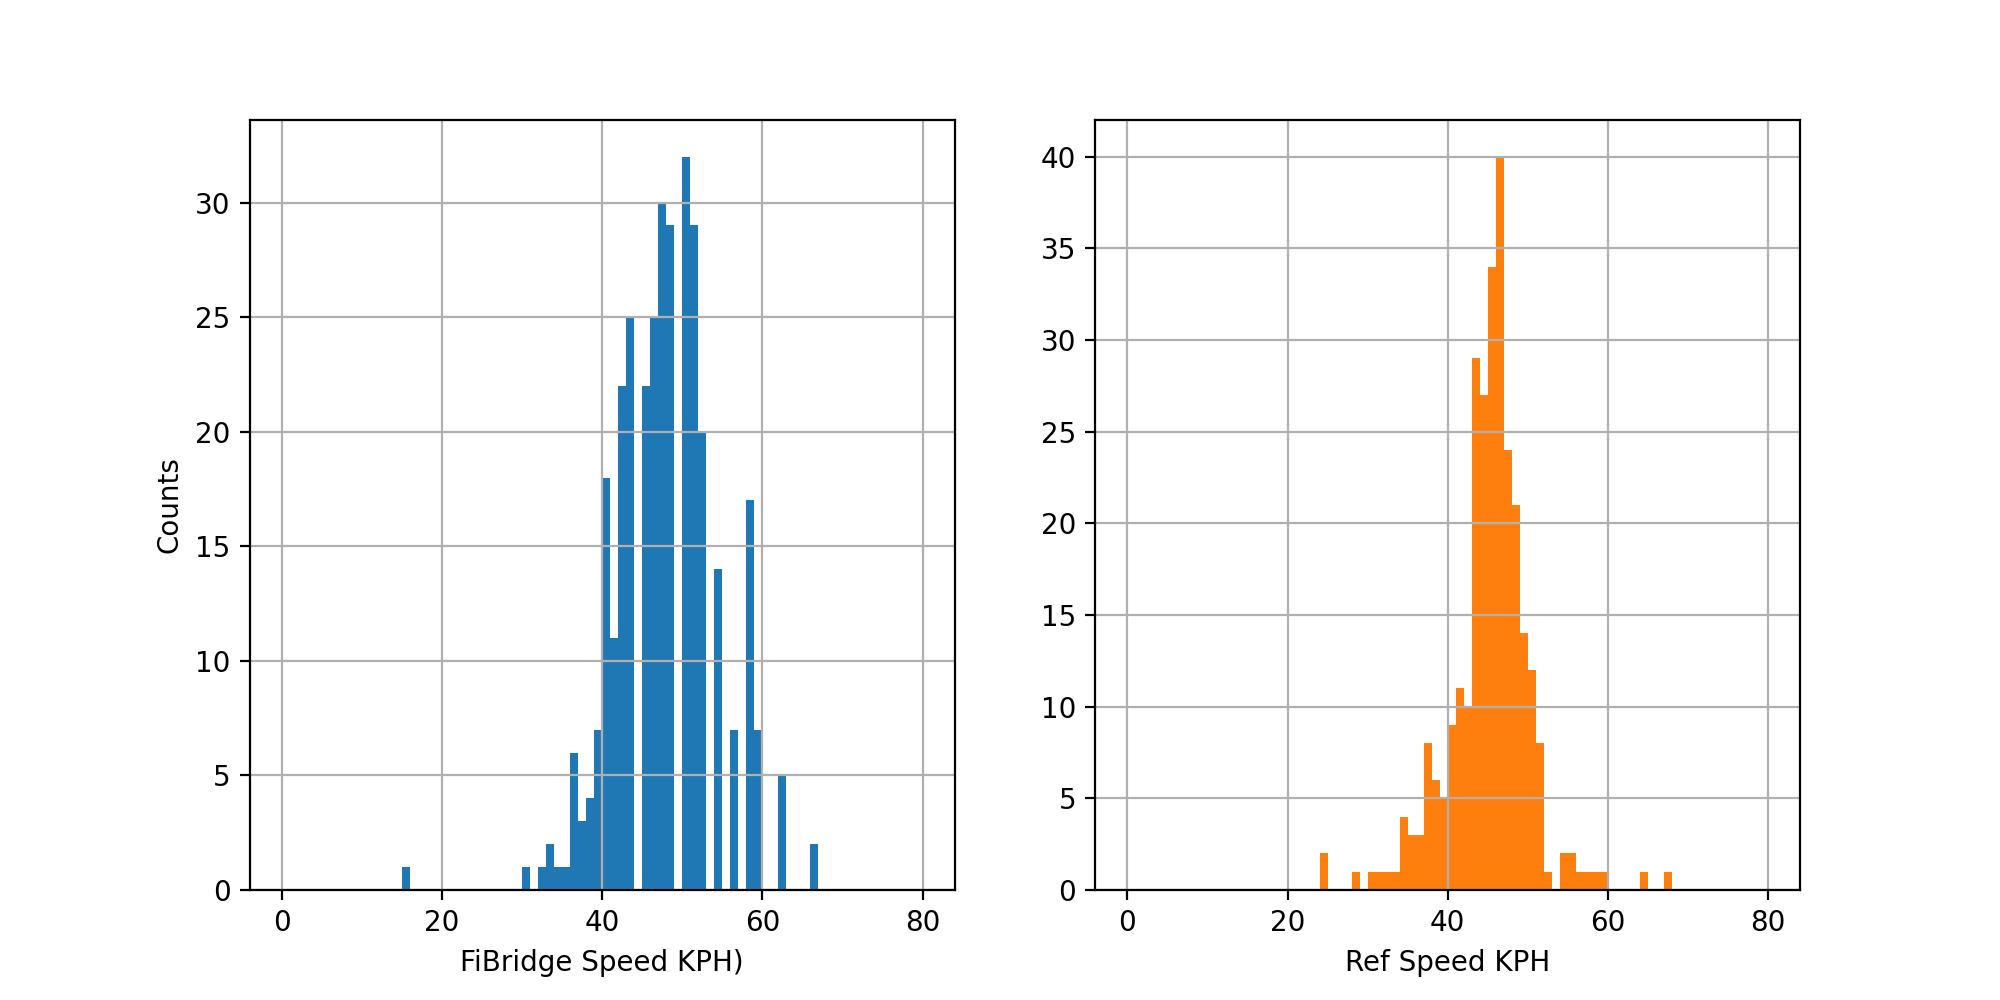

Text(0.5, 0, 'Ref Speed KPH')

In [28]:
plt.figure()
plt.clf()
plt.subplot(1,2,1)
plt.hist(event_speed, bins=np.linspace(0, 80, 81))
plt.xlabel('FiBridge Speed KPH)')
plt.grid()
plt.ylabel('Counts')
plt.subplot(1,2,2)
plt.hist(ref_speed, bins=np.linspace(0,80,81), color='C1')
plt.grid()
plt.xlabel('Ref Speed KPH')

2020-12-01 10:09:25.202698
corr speed-72.0, 46.15384615384615


<IPython.core.display.Javascript object>


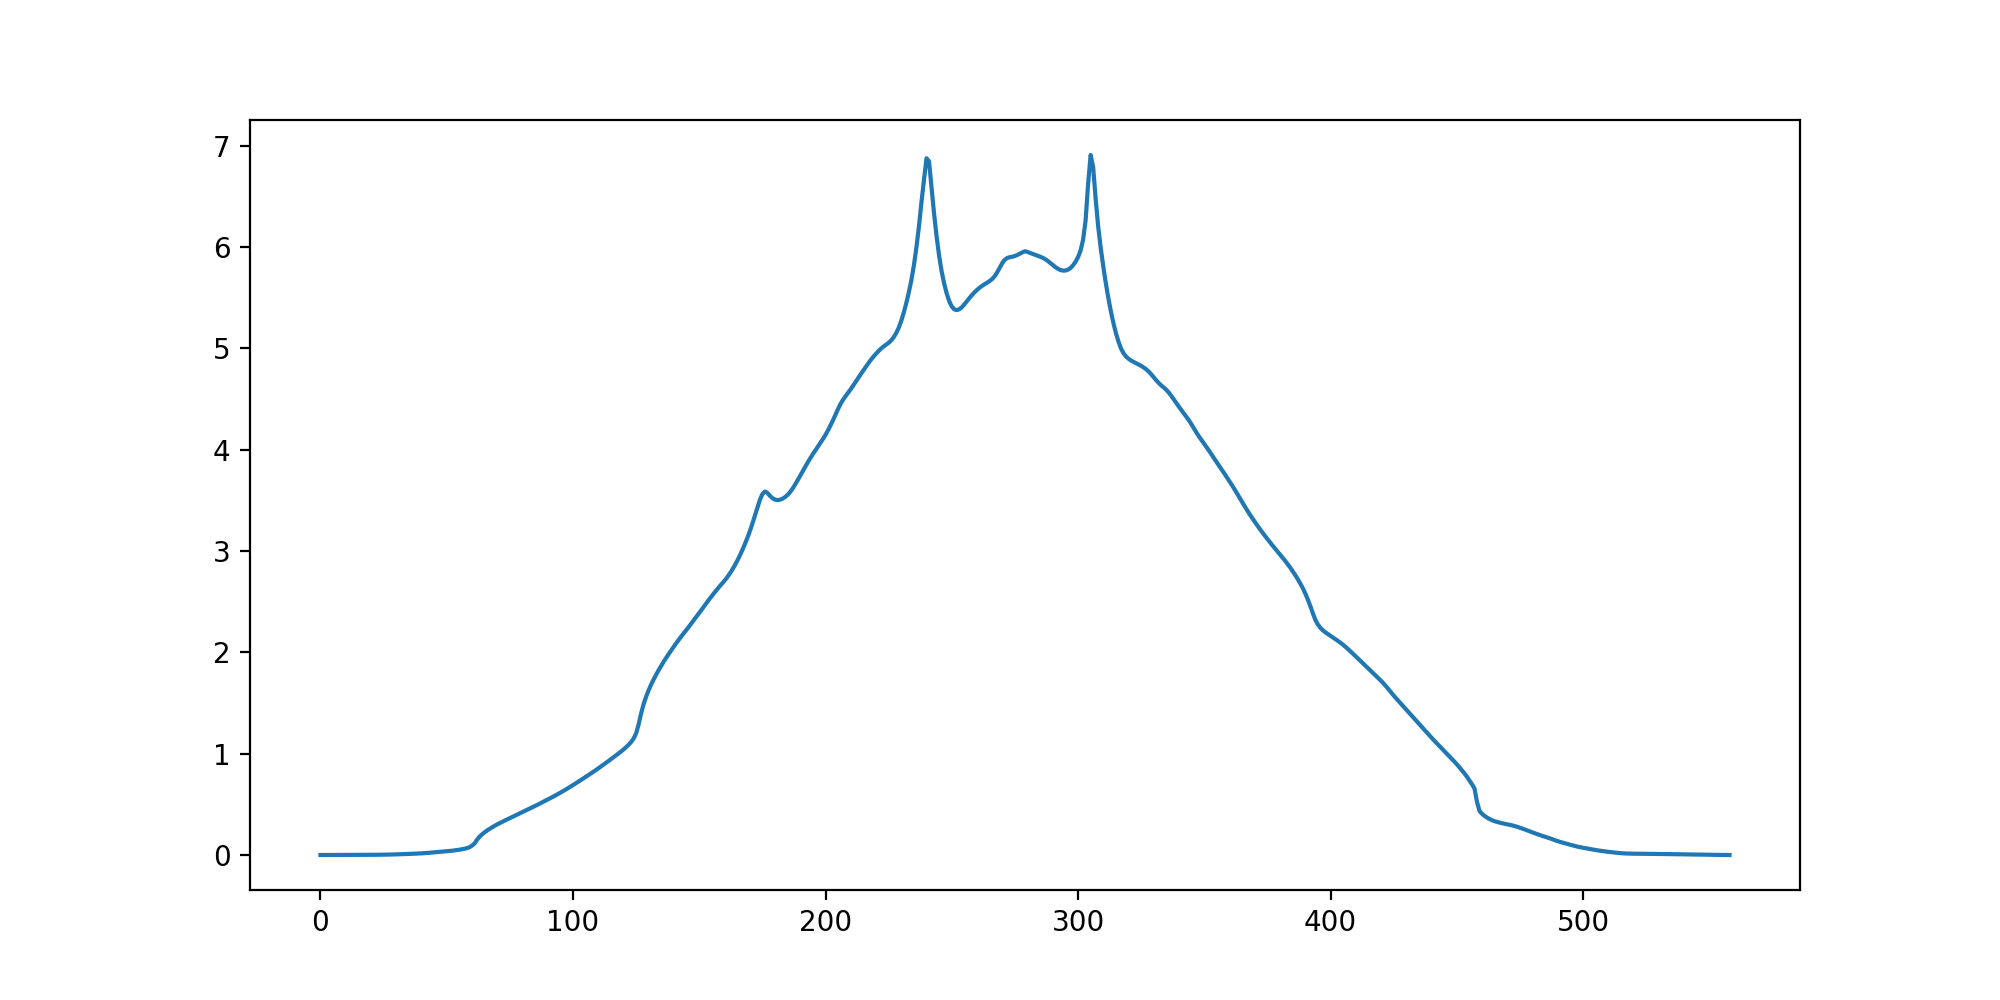

<IPython.core.display.Javascript object>


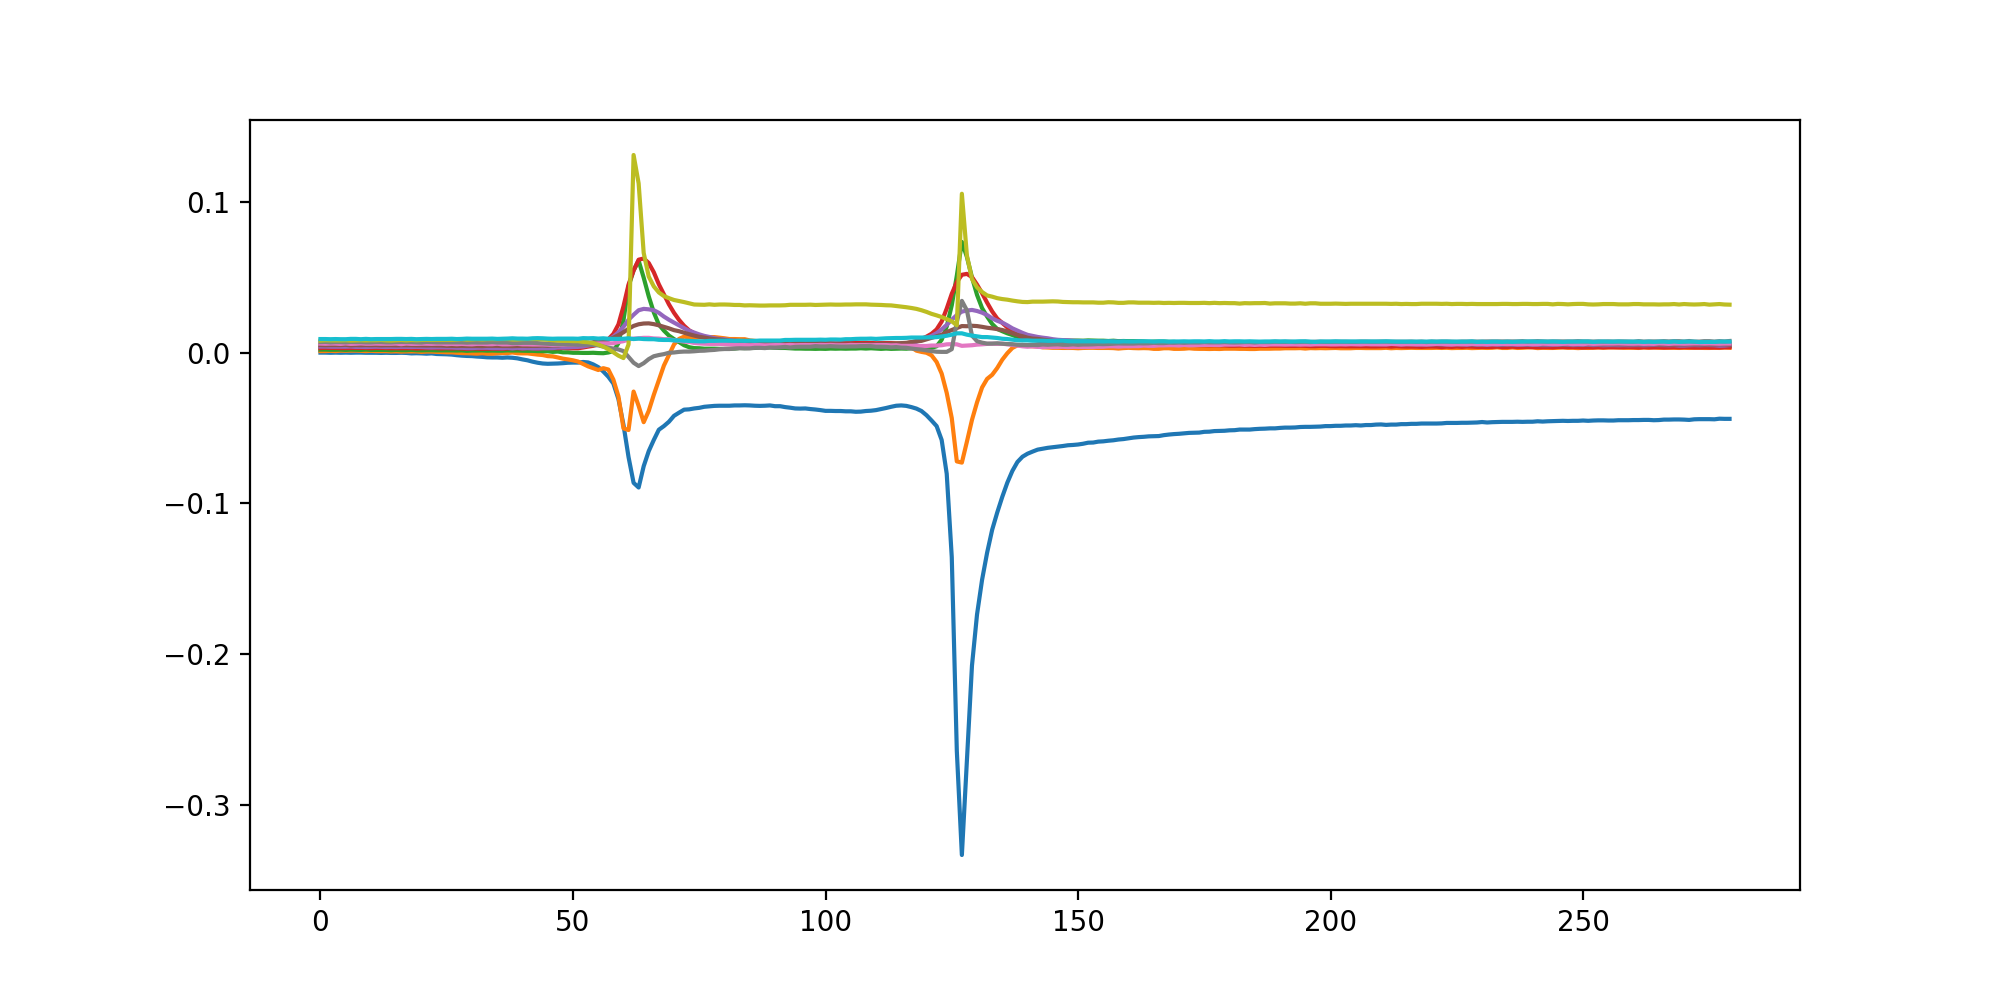

<IPython.core.display.Javascript object>


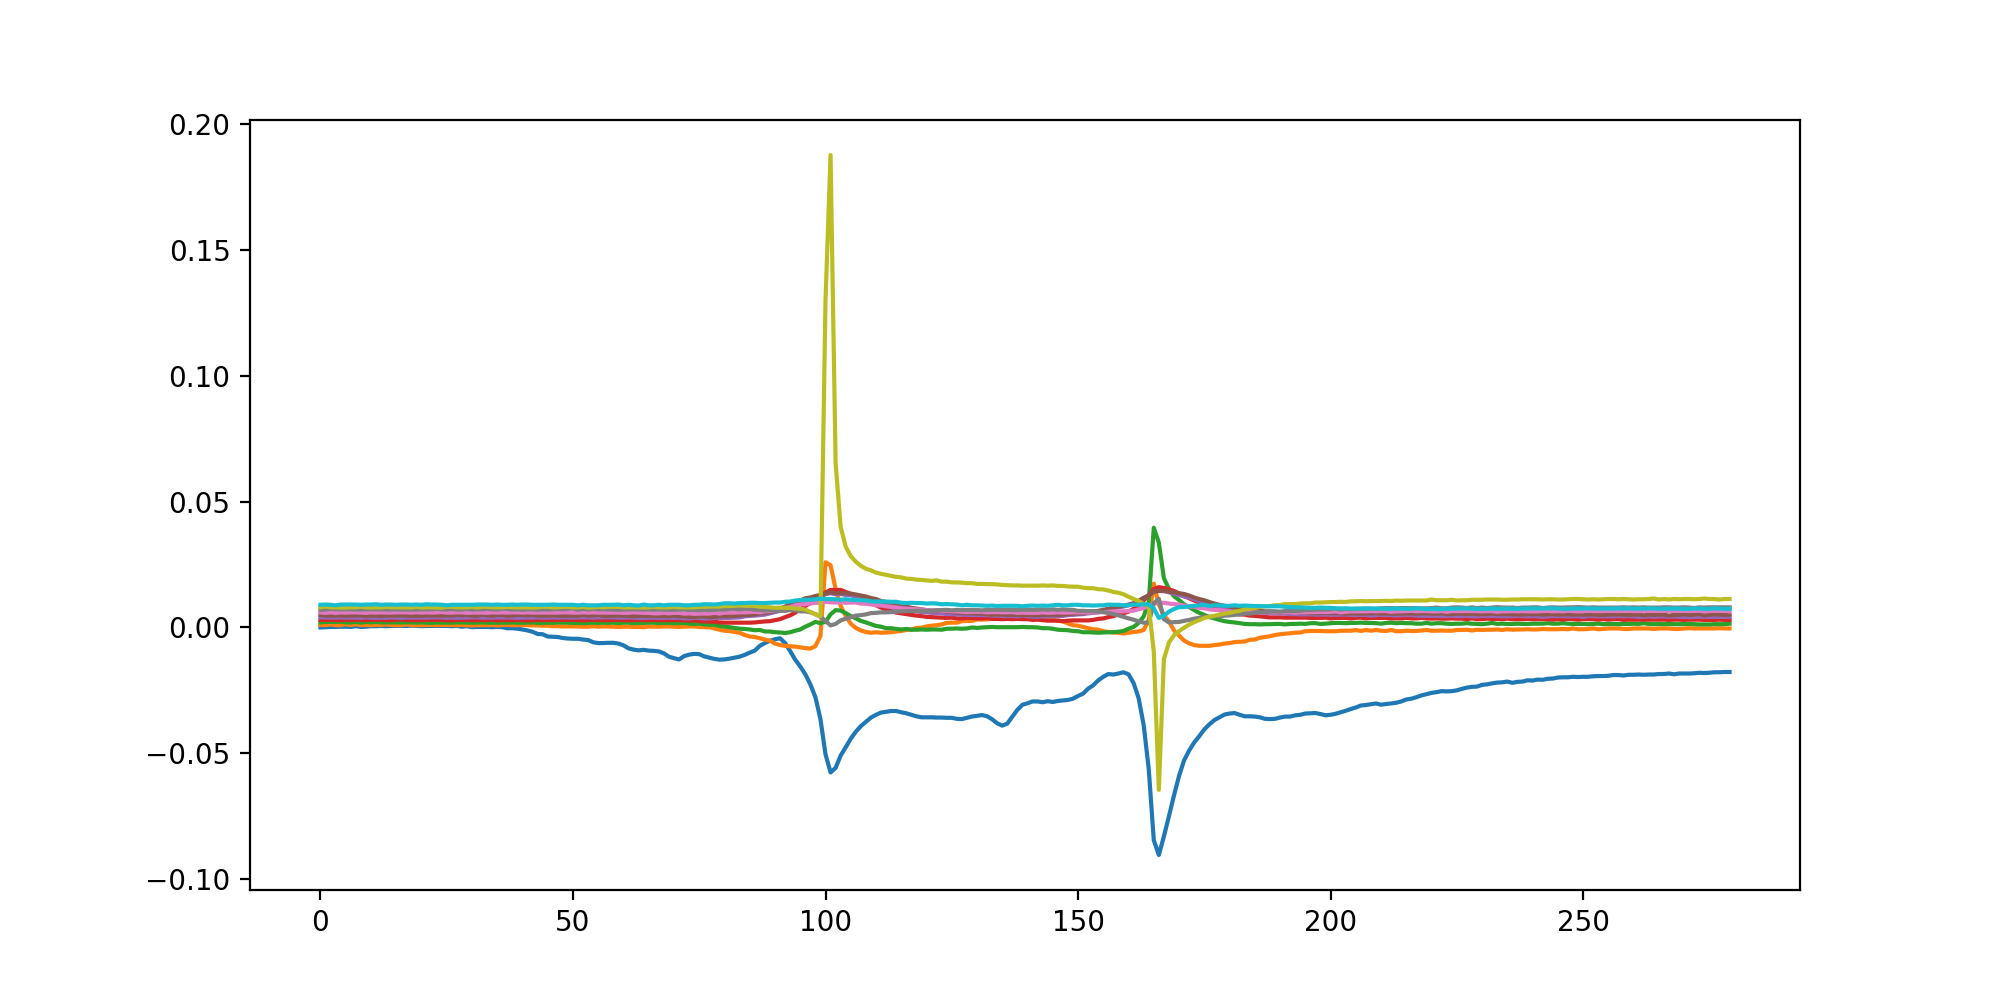

<IPython.core.display.Javascript object>


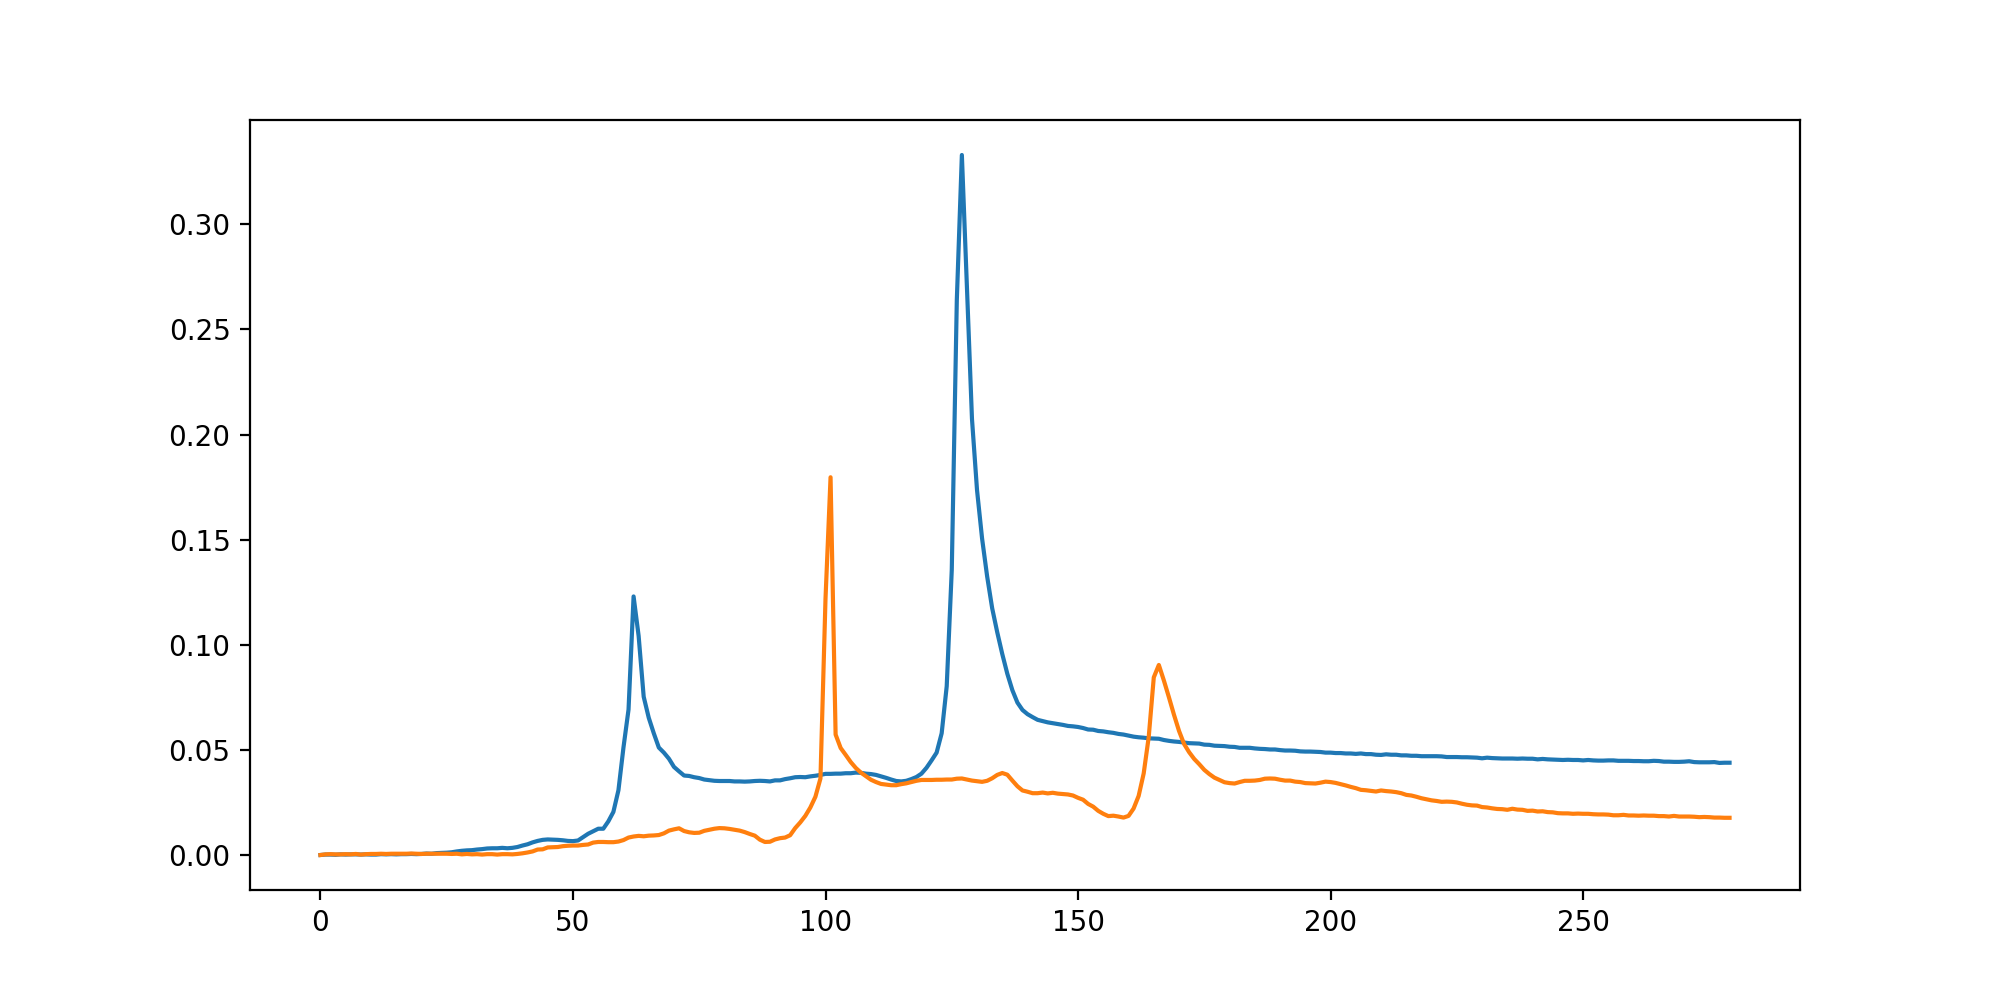

<IPython.core.display.Javascript object>


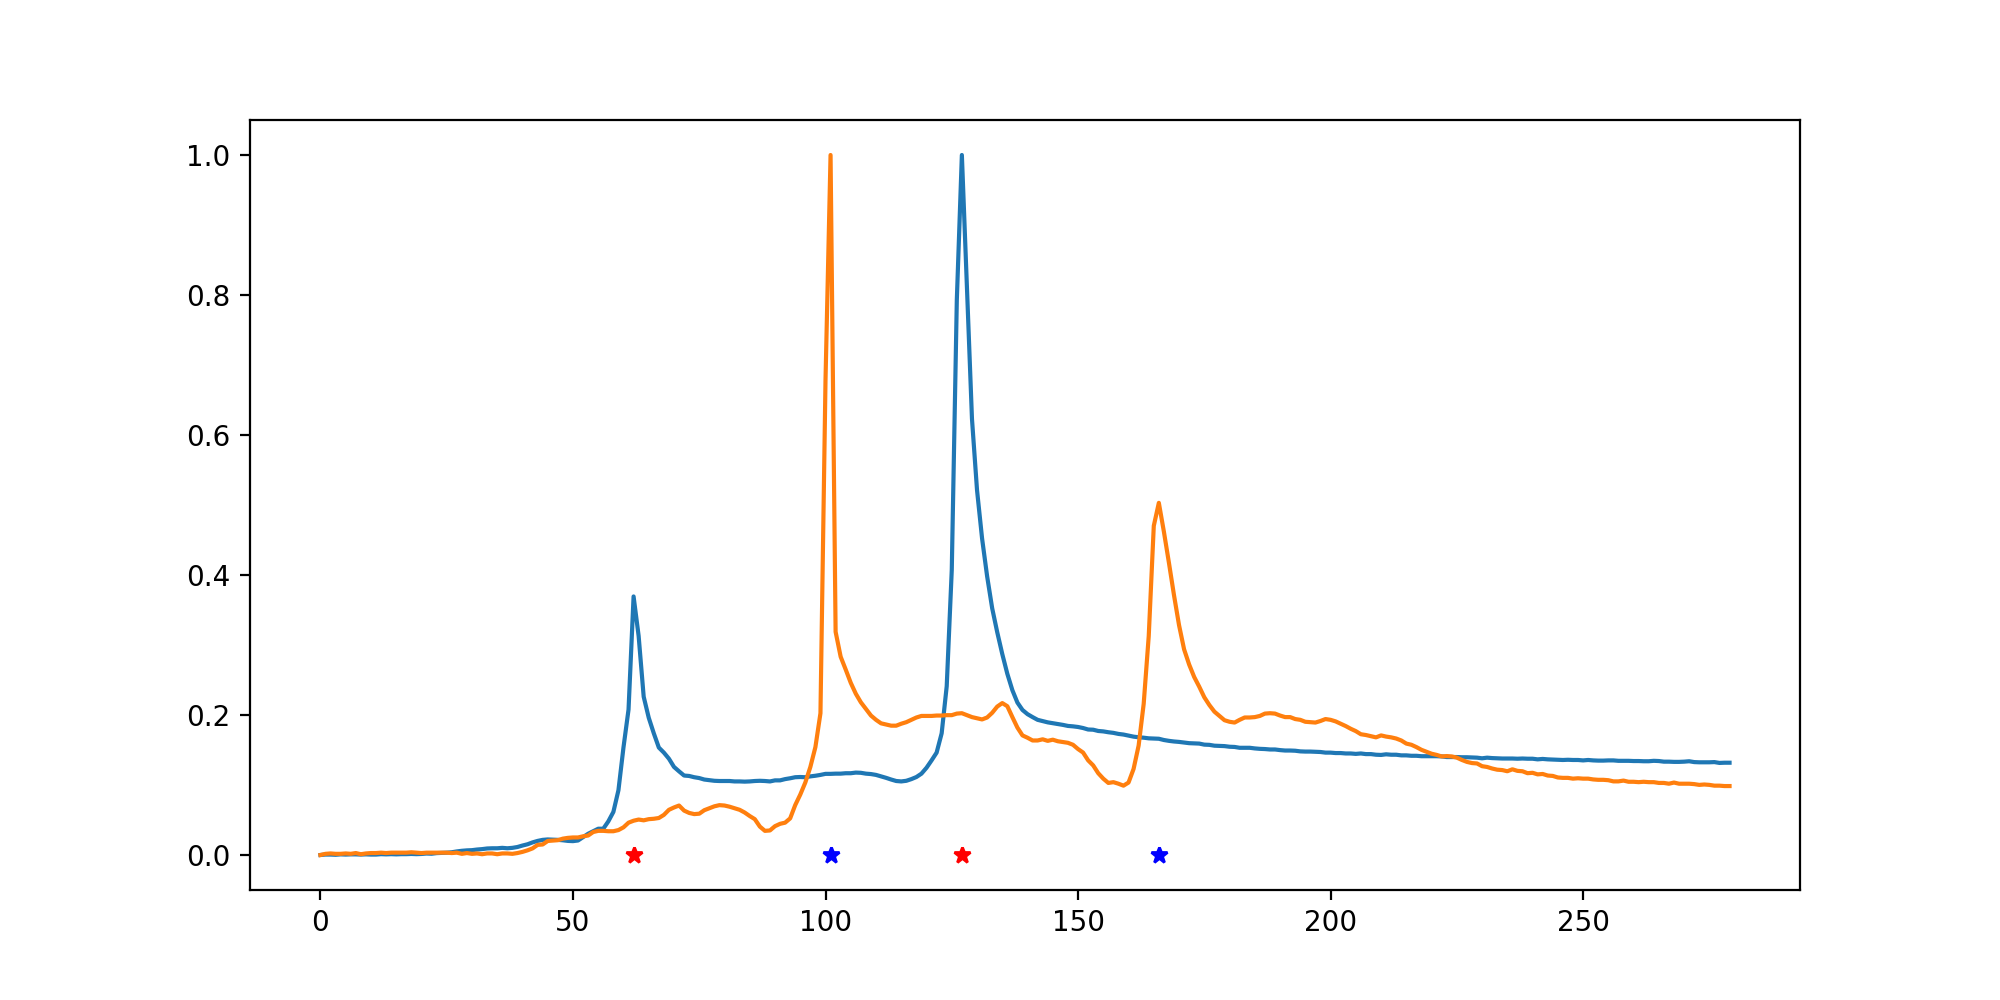

In [33]:
# look at individual event to tune parameters
i = 193

print(events.events[i].timestamp + datetime.timedelta(hours=11))
   
sos = signal.butter(1, 5, 'hp', fs=SAMPLING_RATE, output='sos')
filtered_wav1 = signal.sosfilt(sos, events.events[i].wav1, axis=0)
filtered_wav2 = signal.sosfilt(sos, events.events[i].wav2, axis=0)

trace_temp1 = np.max(np.abs(events.events[i].wav1[:, lane_sensor]), axis=1)
trace_temp2 = np.max(np.abs(events.events[i].wav2[:, lane_sensor]), axis=1)



scaled_values_1 = normalize_maxmin(trace_temp1)
scaled_values_2 = normalize_maxmin(trace_temp2)

scaled_peak1 = signal.find_peaks(np.abs(scaled_values_1), prominence=0.2)
scaled_peak2 = signal.find_peaks(np.abs(scaled_values_2), prominence=0.2)

if len(scaled_peak1[0])*len(scaled_peak2[0])>0:
    peak_speed = -1*FIBER_DISTANCE/(scaled_peak1[0][0]-scaled_peak2[0][0])*SAMPLING_RATE*3.6
else:
    peak_speed = 0

speed_valid = signal.correlate(scaled_values_1, scaled_values_2)
print('corr speed{}, {}'.format(-1 * FIBER_DISTANCE / (speed_valid.argmax() - len(events.events[i].wav1)) * SAMPLING_RATE * 3.6, peak_speed))

plt.figure()
plt.plot(speed_valid)

plt.figure()
plt.clf()
for j in lane_sensor:
#     plt.plot(event_list[j].data['timestamp'].astype('datetime64'), np.asarray(event_list[j].data['leading'].iloc[:,i]) - event_list[j].data['leading'].iloc[0,i] + 0.001 * i)
    plt.plot(np.asarray(events.events[i].wav1[:, j] + 0.001 * j))
#     plt.title('#{}. Timestamp: {}. Estimated speed {:2.2f} KPH'.format(j, event_prop_list[j].timestamp+datetime.timedelta(hours=11), event_prop_list[j].speed))
plt.figure()
plt.clf()
for j in lane_sensor:
#     plt.plot(event_list[j].data['timestamp'].astype('datetime64'), np.asarray(event_list[j].data['leading'].iloc[:,i]) - event_list[j].data['leading'].iloc[0,i] + 0.001 * i)
    plt.plot(np.asarray(events.events[i].wav2[:, j] + 0.001 * j))
#     plt.title('#{}. Timestamp: {}. Estimated speed {:2.2f} KPH'.format(j, event_prop_list[j].timestamp+datetime.timedelta(hours=11), event_prop_list[j].speed))
    
    
plt.figure()
plt.clf()
plt.plot(trace_temp1)
plt.plot(trace_temp2)

plt.figure()
plt.clf()
plt.plot(scaled_values_1)
plt.plot(scaled_values_2)
plt.plot(scaled_peak1[0], [0,]*len(scaled_peak1[0]), '*r')
plt.plot(scaled_peak2[0], [0,]*len(scaled_peak2[0]), '*b')

<IPython.core.display.Javascript object>


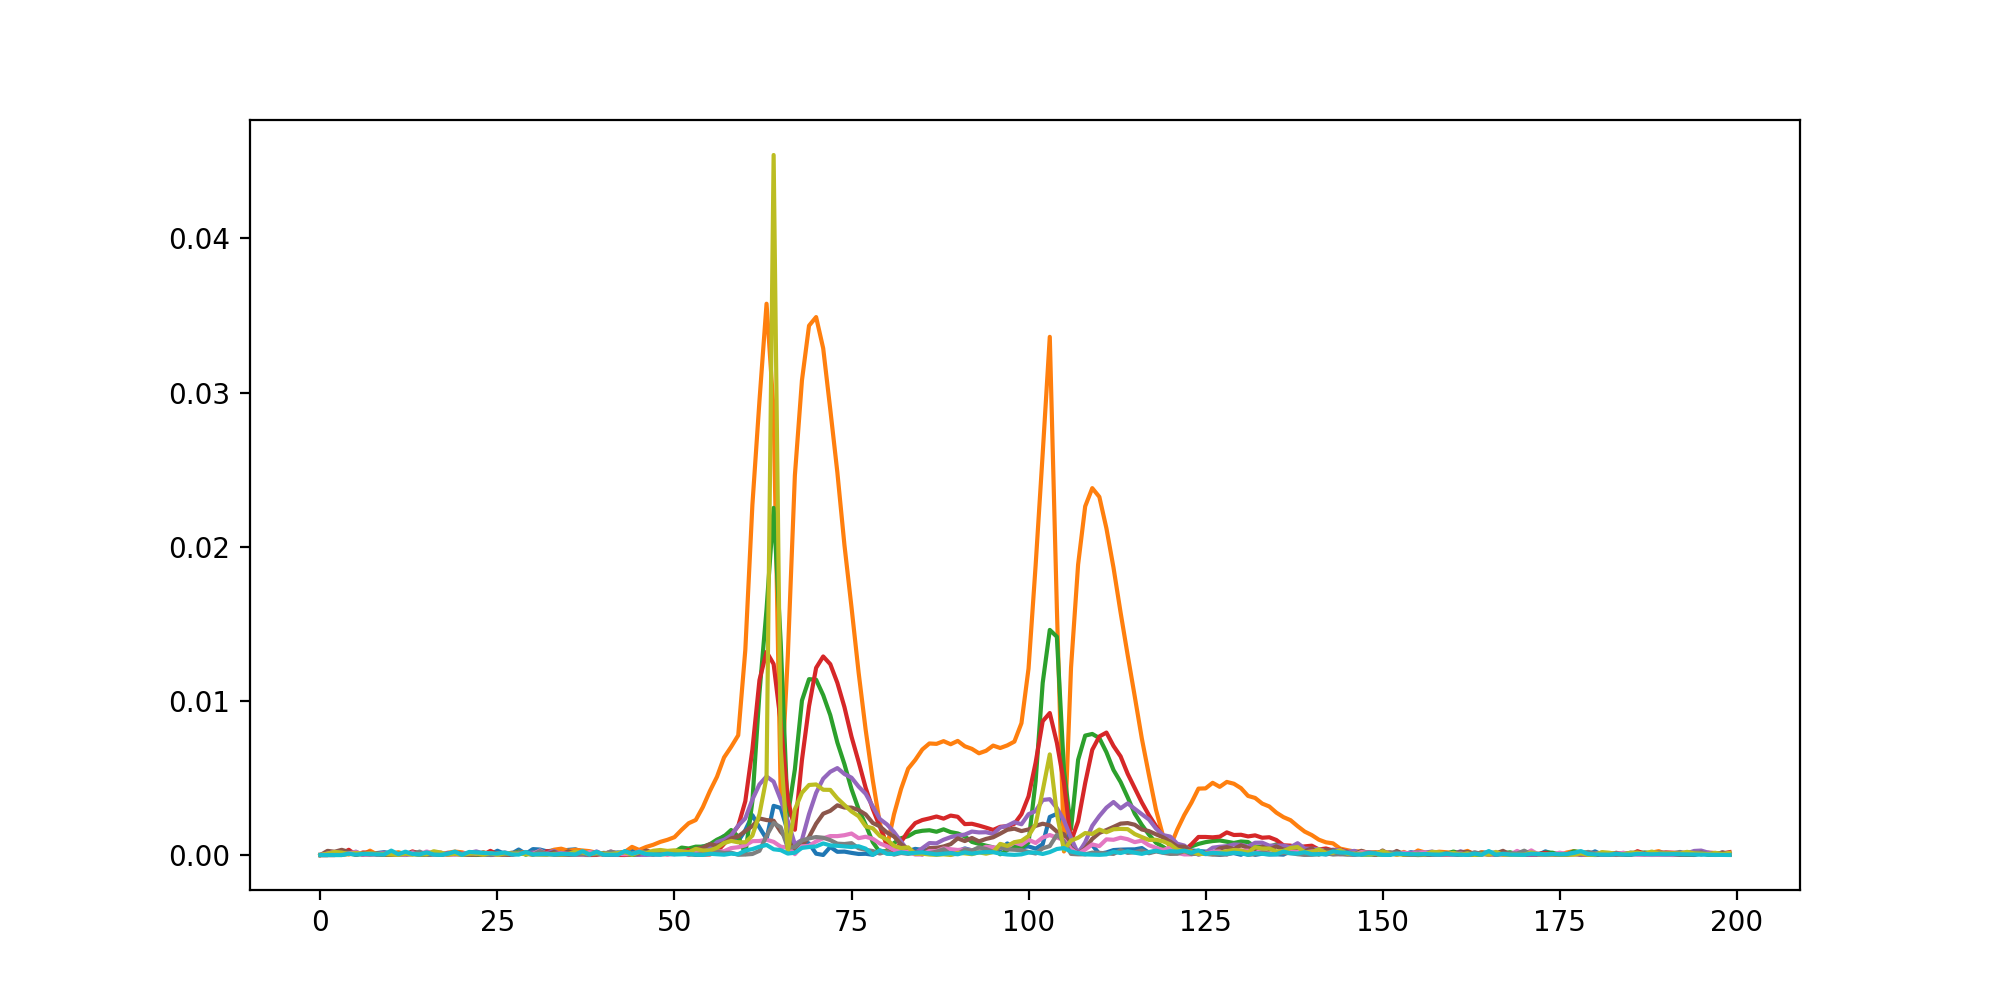

<IPython.core.display.Javascript object>


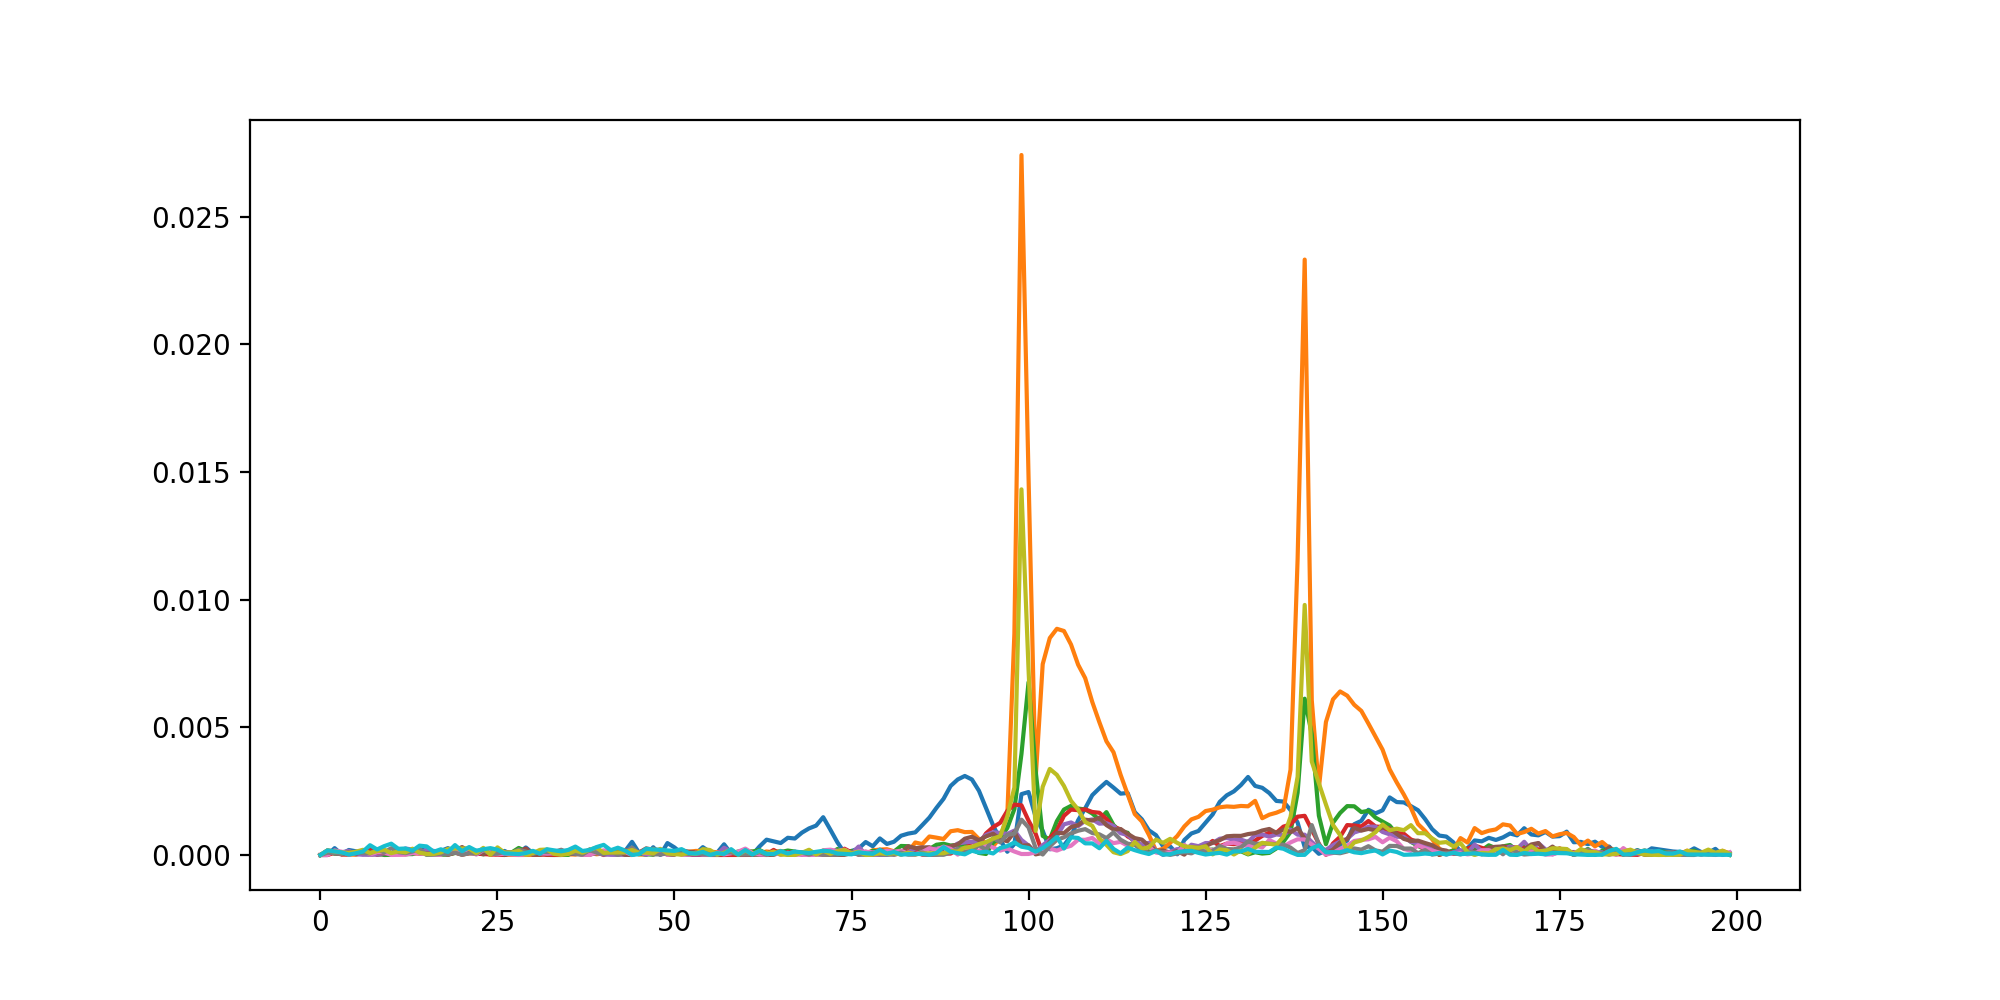

In [25]:
i=121
sos = signal.butter(2, 5, 'hp', fs=200, output='sos')

plt.figure()
plt.plot()
for j in lane_sensor:
    filtered = signal.sosfilt(sos, events.events[i].wav1[:, j])
    plt.plot(np.abs(filtered)+0.000*j)

plt.figure()
for j in lane_sensor:
    filtered = signal.sosfilt(sos, events.events[i].wav2[:, j])
    plt.plot(np.abs(filtered)+0.000*j)
    


In [ ]:
sos = signal.butter(1, 10, 'hp', fs=200, output='sos')
filtered = signal.sosfilt(sos, events.events[i].wav2, axis=0)

In [ ]:
plt.figure()
plt.plot(filtered)

In [ ]:
plt.figure()
plt.plot(scaled_values_1)